# Import libs

In [53]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
import scipy.io
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from models.dgf import DeepGuidedFilterGuidedMapConvGF

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

# Choose figure

In [54]:
file_name  = 'data/inpainting/inpainting.mat'

mat = scipy.io.loadmat(file_name)
img_np = mat["image"].astype(np.float32)
img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(dtype)
img_mask_np = mat["mask"].astype(np.float32)
img_mask_np = np.expand_dims(img_mask_np,2)
img_mask_np = img_mask_np.transpose(2,0,1)
img_mask_var = torch.from_numpy(img_mask_np).type(dtype)

# ensure dimensions [0][1] are divisible by 32 (or 2^depth)!

# Downsample image

In [55]:
from skimage.transform import resize
radius = 2
x_w, x_h = img_np.shape[1:]
w, h = x_w // radius, x_h // radius
img_lr_np = resize(img_np, (img_np.shape[0], w, h), order=0, mode='reflect')
img_lr_mask_np = resize(img_mask_np, (img_mask_np.shape[0], w, h), order=0, mode='reflect')
I_lr_np = img_lr_np
I_hr_np = img_np
img_lr_var = torch.from_numpy(img_lr_np).type(dtype)
img_lr_mask_var = torch.from_numpy(img_lr_mask_np).type(dtype)

### Visualize

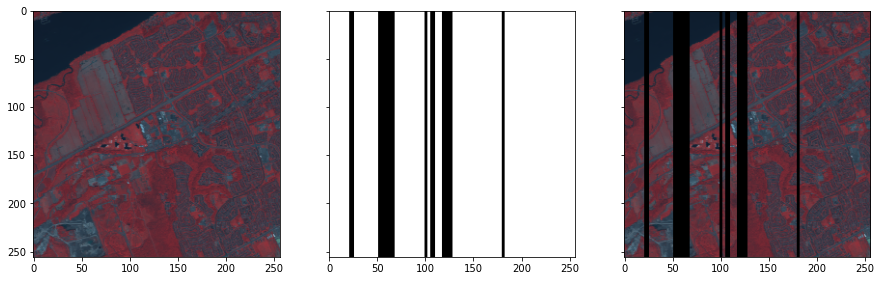

In [58]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(torch.stack((img_var[56,:,:].cpu(),img_var[26,:,:].cpu(),img_var[16,:,:].cpu()),2))
ax2.imshow(img_mask_var.permute(1,2,0).cpu().squeeze(), cmap='gray') 
ax3.imshow(torch.stack(((img_var[56,:,:]*img_mask_var[0,:,:]).cpu(),(img_var[26,:,:]*img_mask_var[0,:,:]).cpu(),(img_var[16,:,:]*img_mask_var[0,:,:]).cpu()),2))
plt.show()

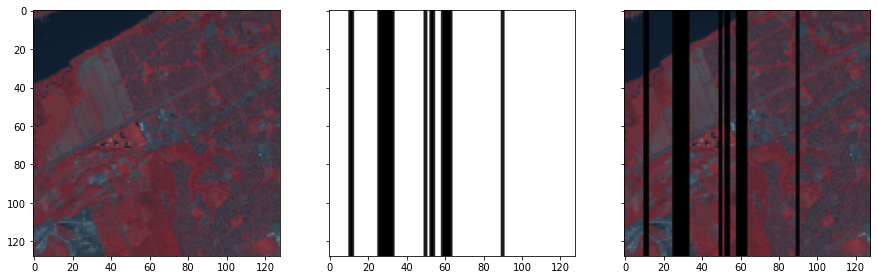

In [56]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(torch.stack((img_lr_var[56,:,:].cpu(),img_lr_var[26,:,:].cpu(),img_lr_var[16,:,:].cpu()),2))
ax2.imshow(img_lr_mask_var.permute(1,2,0).cpu().squeeze(), cmap='gray') 
ax3.imshow(torch.stack(((img_lr_var[56,:,:]*img_lr_mask_var[0,:,:]).cpu(),(img_lr_var[26,:,:]*img_lr_mask_var[0,:,:]).cpu(),(img_lr_var[16,:,:]*img_lr_mask_var[0,:,:]).cpu()),2))
plt.show()

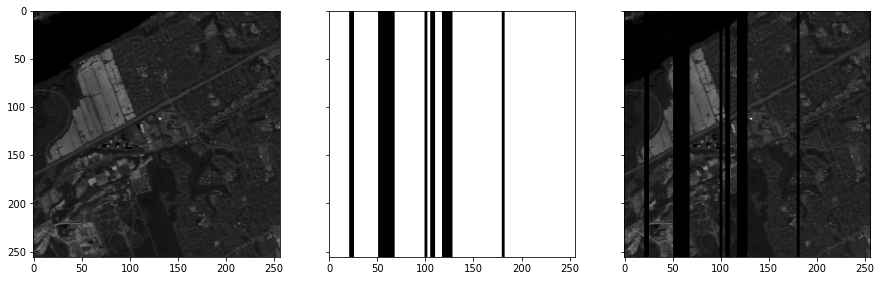

In [4]:
# band to visualize
band = 150

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(img_var[band,:,:].cpu(), cmap='gray')
ax2.imshow(img_mask_var.permute(1,2,0).cpu().squeeze(), cmap='gray') 
ax3.imshow((img_var*img_mask_var)[band,:,:].cpu(), cmap='gray')
plt.show()

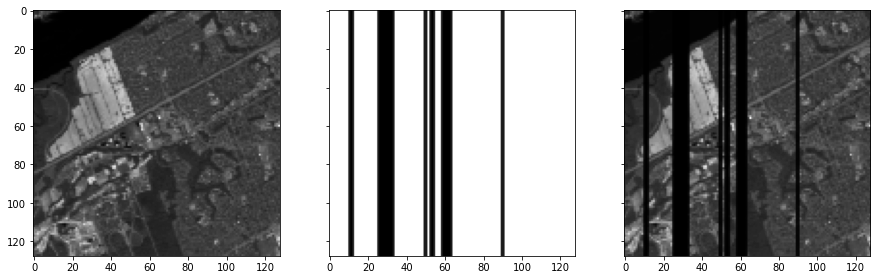

In [5]:
# band to visualize
band = 150

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(img_lr_var[band,:,:].cpu(), cmap='gray')
ax2.imshow(img_lr_mask_var.permute(1,2,0).cpu().squeeze(), cmap='gray') 
ax3.imshow((img_lr_var*img_lr_mask_var)[band,:,:].cpu(), cmap='gray')
plt.show()

# Setup

In [6]:
pad = 'reflection' #'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

method = '2D'
input_depth = img_np.shape[0] 
LR = 0.01  
num_iter = 10001
param_noise = False
reg_noise_std = 0.1 # 0 0.01 0.03 0.05

show_every = 1000
save_every = 1000

net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [128] * 5, 
           num_channels_up =   [128] * 5,
           num_channels_skip =    [128] * 5,  
           filter_size_up = 3, filter_size_down = 3, 
           upsample_mode='nearest', filter_skip_size=1,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

'''
# UNet

reg_noise_std = 0.02
LR = 0.001

net = UNet(num_input_channels=input_depth, num_output_channels=img_np.shape[0], 
           feature_scale=8, more_layers=1, 
           concat_x=False, upsample_mode='deconv', 
           pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
'''


'''
#ResNet

reg_noise_std = 0.02
LR = 0.001
net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')

LR = 0.001
param_noise = False
'''        

net = net.type(dtype)
net_input = get_noise(input_depth, method, img_lr_np.shape[1:]).type(dtype)

In [7]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_var = img_var[None, :].cuda()
img_lr_var = img_lr_var[None, :].cuda()
img_mask_var = img_mask_var[None, :].cuda()
img_lr_mask_var = img_lr_mask_var[None, :].cuda()

Number of params: 3203628


# Main loop

Starting optimization with ADAM


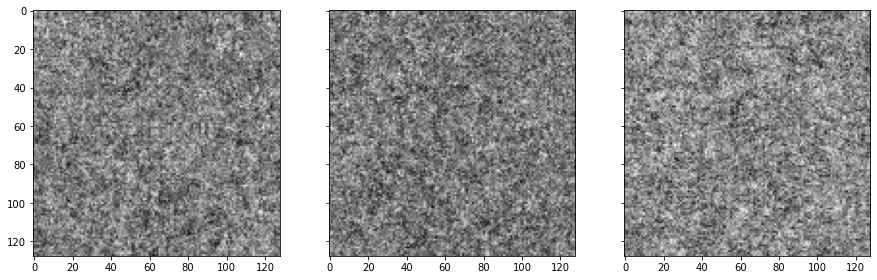

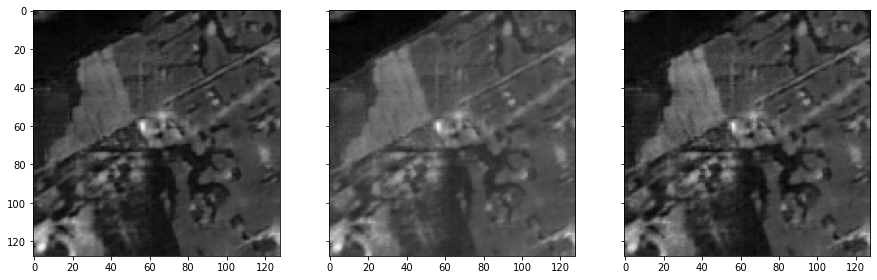

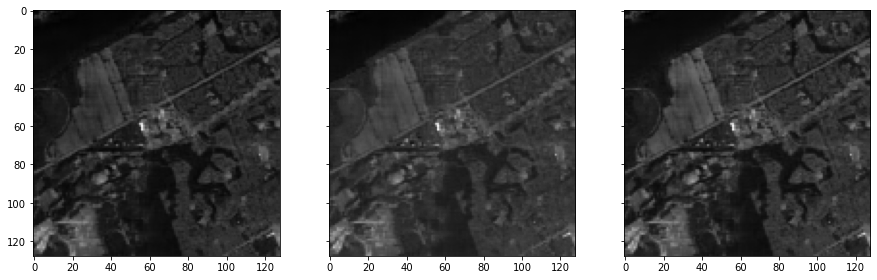

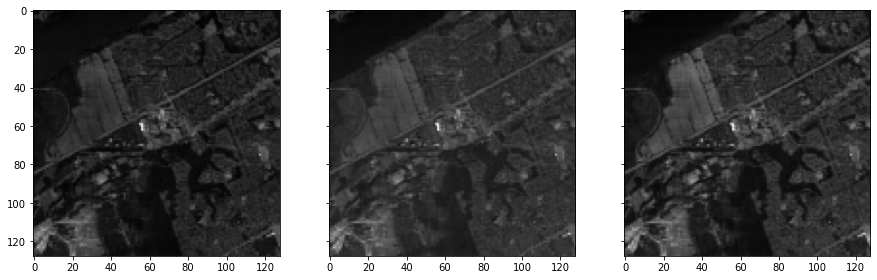

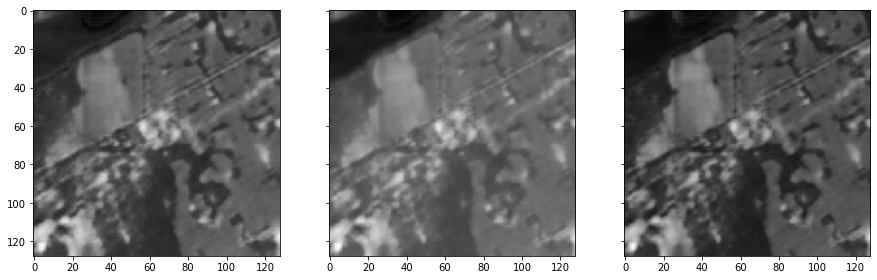

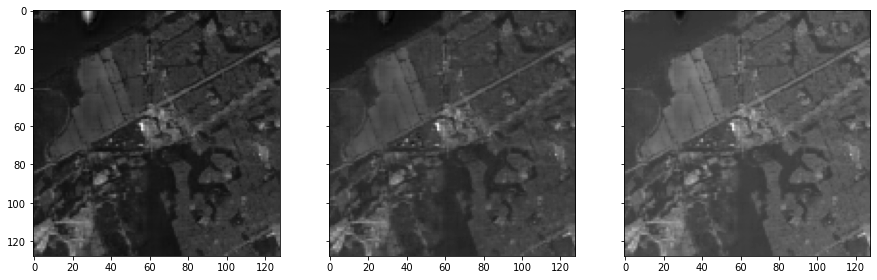

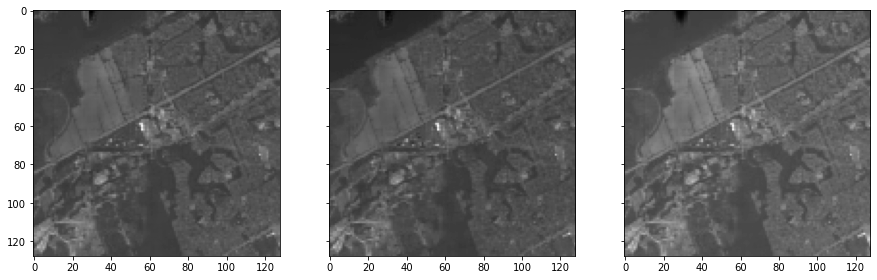

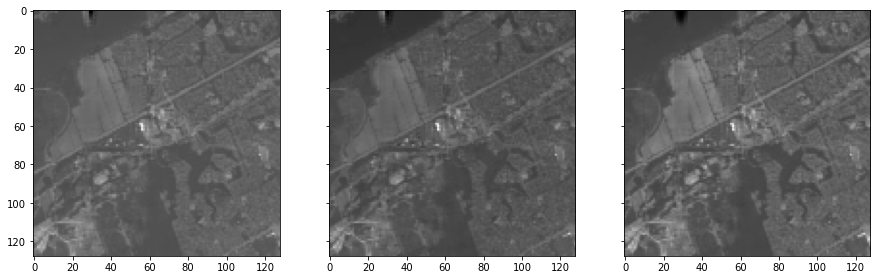

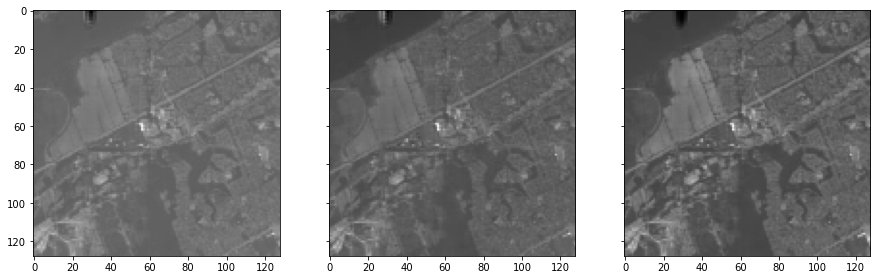

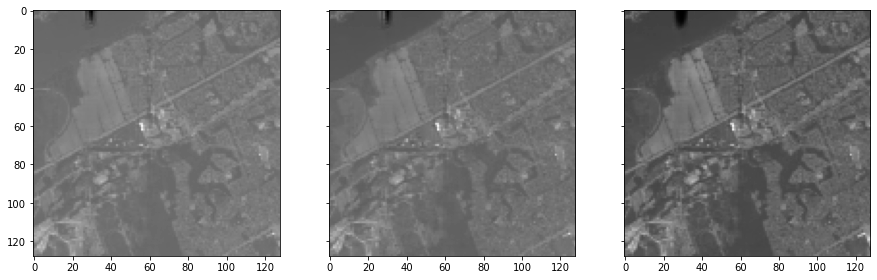

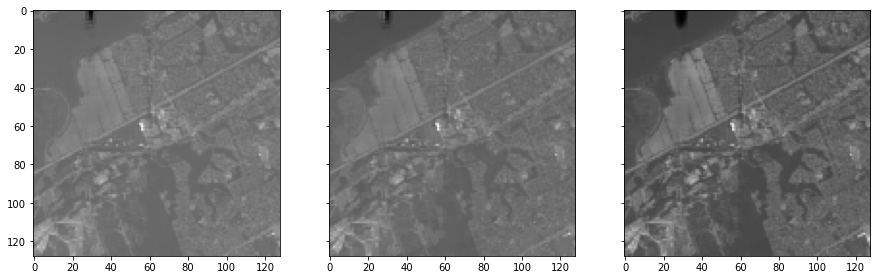

In [8]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
         
    out = net(net_input)
    
    total_loss = mse(out * img_lr_mask_var, img_lr_var * img_lr_mask_var)
    total_loss.backward()
        
        
        
    # print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  i % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(out_np[2,:,:], cmap='gray')
        ax2.imshow(out_np[8,:,:], cmap='gray')
        ax3.imshow(out_np[18,:,:], cmap='gray')
        plt.show()
        psrn_masked = peak_signal_noise_ratio(img_lr_np* img_lr_mask_np, out.detach().cpu().numpy()[0] * img_lr_mask_np) 
        psrn = peak_signal_noise_ratio(img_lr_np, out.detach().cpu().numpy()[0]) 
        print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')
        
    if  i % save_every == 0:
        out_np = out.detach().cpu().squeeze().numpy()
        scipy.io.savemat("results/result_inpainting_2D_lr_it%d.mat" % (i), {'pred':out_np.transpose(1,2,0)})
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

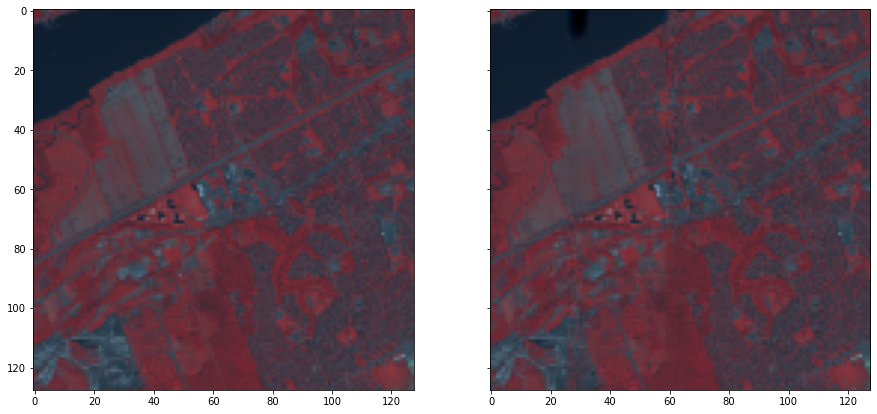

In [9]:
# load result
file_name = 'C:\\Users\\Yu\\Downloads\\deep-hs-prior\\data\\inpainting\\results\\result_inpainting_2D_lr_it10000.mat'
mat = scipy.io.loadmat(file_name)
result_np = mat["pred"]
result_np = result_np.transpose(2,0,1)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(np.stack((img_lr_np[56,:,:],img_lr_np[26,:,:],img_lr_np[16,:,:]),2))
ax2.imshow(np.stack((result_np[56,:,:],result_np[26,:,:],result_np[16,:,:]),2))
plt.show()

# Upsample image

In [10]:
net_output = net(net_input)
model = DeepGuidedFilterGuidedMapConvGF(radius,img_np.shape[0]).cuda()
I_lr = np_to_torch(I_lr_np*img_lr_mask_np).type(dtype)
I_hr = np_to_torch(I_hr_np*img_mask_np).type(dtype)
mse_t = torch.nn.MSELoss().type(dtype)

Starting optimization with ADAM


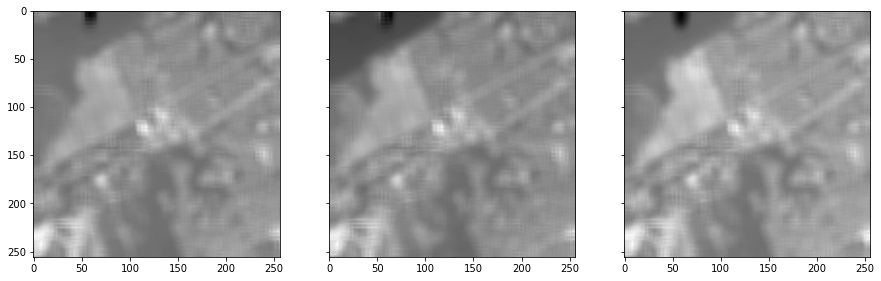

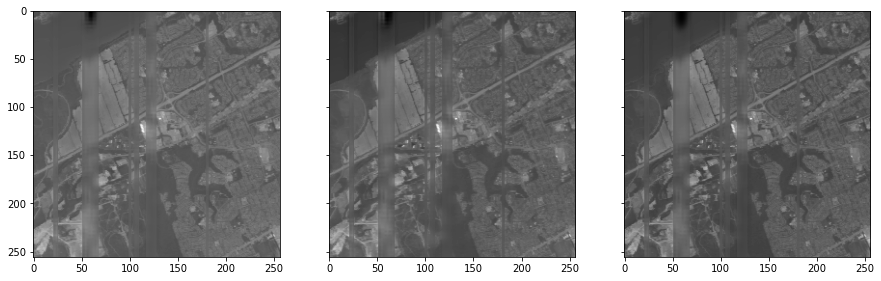

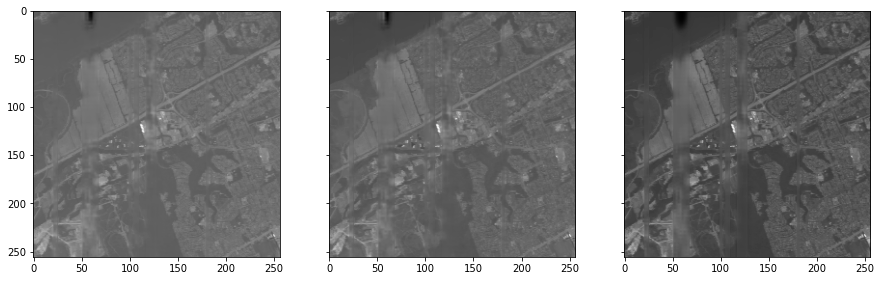

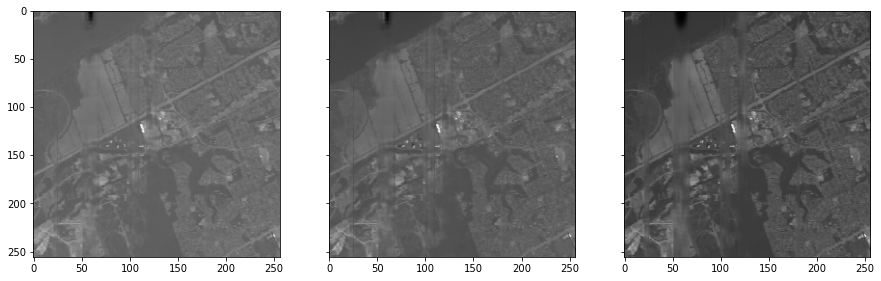

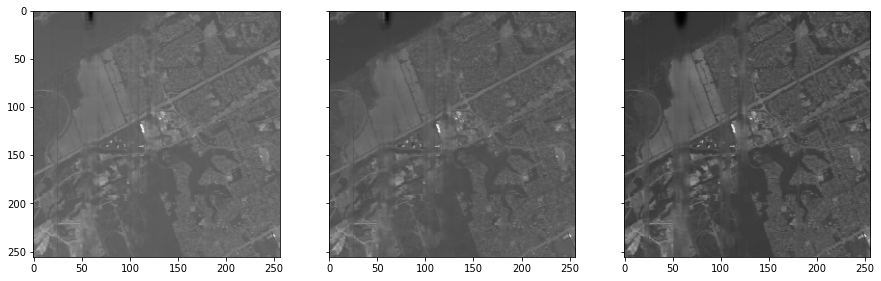

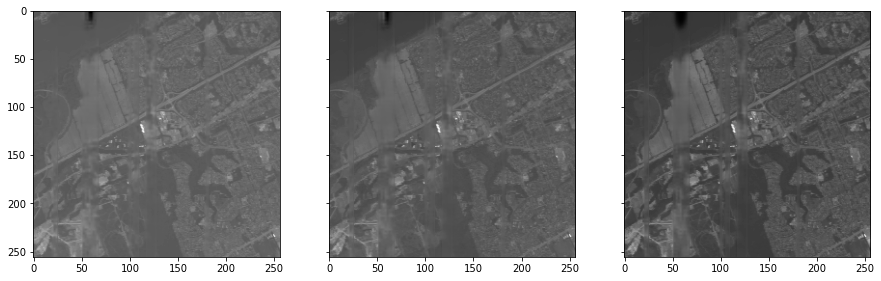

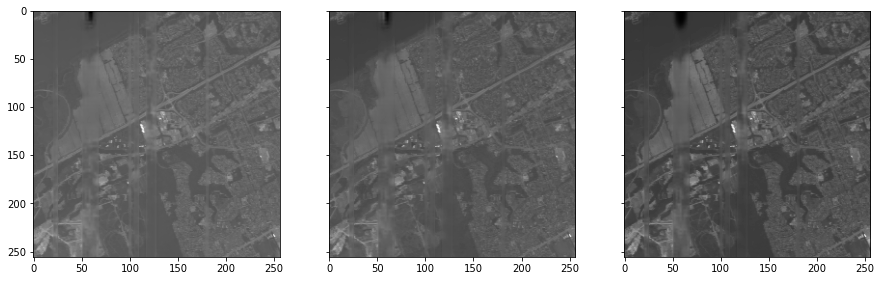

In [11]:
i = 0

def closure_t():
    global i
    out = model(I_lr,net_output,I_hr)
    total_loss = mse_t(out*img_mask_var,img_var * img_mask_var)


    total_loss.backward(retain_graph=True)
    
    
    # print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if i % 100 == 0:
        out_np = out.detach().cpu().squeeze().numpy()
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(out_np[2,:,:], cmap='gray')
        ax2.imshow(out_np[8,:,:], cmap='gray')
        ax3.imshow(out_np[18,:,:], cmap='gray')
        plt.show()
        scipy.io.savemat("results/result_inpainting_2D_hr_it%d.mat" % (i), {'pred':out_np.transpose(1,2,0)})
        psrn_masked = peak_signal_noise_ratio(img_np* img_mask_np, out.detach().cpu().numpy()[0] * img_mask_np) 
        psrn = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
        print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')

    i+=1
    return total_loss

p_t = get_params(OPT_OVER, model,I_lr)
optimize(OPTIMIZER, p_t, closure_t, LR, 601)


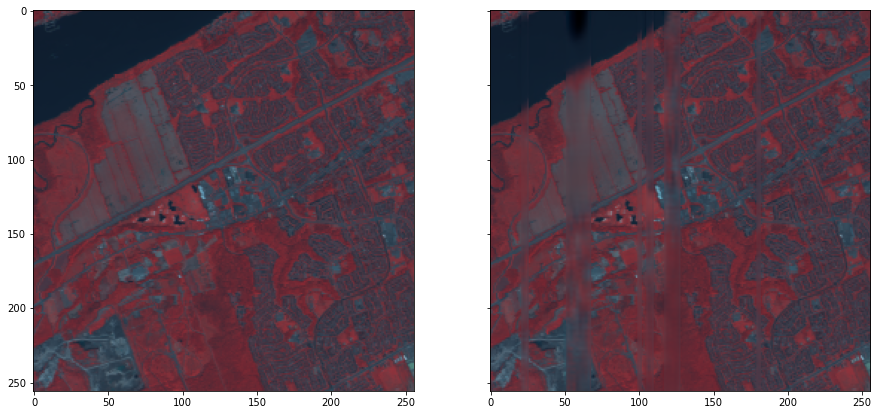

In [13]:
# load result
file_name = "results/result_inpainting_2D_hr_it600.mat"
mat = scipy.io.loadmat(file_name)
result_np = mat["pred"]
result_np = result_np.transpose(2,0,1)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(np.stack((img_np[56,:,:],img_np[26,:,:],img_np[16,:,:]),2))
ax2.imshow(np.stack((result_np[56,:,:],result_np[26,:,:],result_np[16,:,:]),2))
plt.show()

# result_var = torch.from_numpy(result_np).type(dtype)
# f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True, figsize=(15,15))
# ax1.imshow(img_var.detach().cpu().numpy()[0,2,:,:], cmap='gray')
# ax2.imshow(img_var.detach().cpu().numpy()[0,8,:,:], cmap='gray')
# ax3.imshow(img_var.detach().cpu().numpy()[0,18,:,:], cmap='gray')

# ax4.imshow(result_var.detach().cpu().numpy()[2,:,:], cmap='gray')
# ax5.imshow(result_var.detach().cpu().numpy()[8,:,:], cmap='gray')
# ax6.imshow(result_var.detach().cpu().numpy()[18,:,:], cmap='gray')
# plt.show()